<a href="https://colab.research.google.com/github/JuanArmas/BigDataSNS/blob/main/Actividad_3_4_JuanArmas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Autor: Juan Airam Armas Alemán
https://github.com/JuanArmas/BigDataSNS/blob/main/Actividad_3_4_JuanArmas.ipynb

## Dataset Casen 2017.

La Encuesta Casen en Chile es un estudio integral que examina la situación de los hogares y la población, enfocándose en aspectos clave como salud, educación, vivienda, trabajo, etnia e ingresos entre otros.

Ampliar el alcance y la profundidad de esta encuesta por medio de la correlación de estas variables entre sí, posibilitaría una comprensión aún más precisa de los desafíos socioeconómicos actuales. Esto podría permitir el diseño de programas y políticas más efectivas, dirigidos a mejorar de manera específica las condiciones de vida de los grupos más vulnerables en la sociedad chilena.

El objetivo que me planteo al abordar este problema de clasificación es anticipar el riesgo de exclusión económica en una parte específica de la población chilena, observando las características más comunes y definiendo las variables que puedan tener una correlación significativa para realizar una predicción efectiva y ajustada. En particular, me enfocaré en prever la vulnerabilidad en relación con el sexo, la etnia y el qautr (distribución del ingreso per cápita del hogar a nivel regional, diferenciando entre zonas urbanas y rurales y medido en quintiles) de la población chilena.

Más información:

https://observatorio.ministeriodesarrollosocial.gob.cl/preguntas-frecuentes#:~:text=Sus%20objetivos%20son%20los%20siguientes,vivienda%2C%20trabajo%2C%20e%20ingresos.


In [ ]:
#Importar librerías y módulos
import pandas as pd
import numpy as np
import io
import seaborn as sns
import matplotlib.pyplot as plt
import math
import plotly.graph_objs as go
from google.colab import files
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB, CategoricalNB
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.svm import SVC



##Carga y normalización de datos:


#### Cargamos datos desde repo local e indicamos con codificación ISO-8859-1, que cree el dataframe y que separe por ","

In [ ]:
def upload_files ():
  #Lee el archivo desde local
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    #Crea el dataFrame separado por ","
    #df_Casen = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), sep=',')
    df_Casen = pd.read_csv(io.StringIO(uploaded[fn].decode('ISO-8859-1')), sep=';')
    return df_Casen

In [ ]:
df_Casen = upload_files()
df_Casen

Saving 01_casen_2017_muestra.csv to 01_casen_2017_muestra (4).csv
User uploaded file "01_casen_2017_muestra (4).csv" with length 14464 bytes


,sexo,sexo_cod,edad,etnia,es_indigena,pobreza_ingreso,esc,ingreso,qaut,qautr
0,Mujer,1,56,Aimara,Indigena,No pobres,12.0,250000.0,3.0,3.0
1,Mujer,1,21,No pertenece a ningún pueblo indígena,No indigena,No pobres,7.0,211091.0,3.0,3.0
2,Hombre,0,24,No pertenece a ningún pueblo indígena,No indigena,No pobres,12.0,281750.0,4.0,4.0
3,Hombre,0,28,No pertenece a ningún pueblo indígena,No indigena,Pobres extremos,12.0,311750.0,4.0,4.0
4,Hombre,0,26,No pertenece a ningún pueblo indígena,No indigena,Pobres extremos,15.0,341667.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...
194,Hombre,0,16,No pertenece a ningún pueblo indígena,No indigena,No pobres,10.0,NaN,4.0,4.0
195,Mujer,1,10,No pertenece a ningún pueblo indígena,No indigena,No pobres,NaN,NaN,4.0,4.0
196,Hombre,0,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,Mujer,1,37,No pertenece a ningún pueblo indígena,No indigena,No pobres,15.0,NaN,4.0,4.0


In [ ]:
# El QAUT se enfoca en la distribución del ingreso per cápita del hogar a nivel nacional.
# El QAUTR considera esta distribución según la zona residencial de los hogares, dividiendo el país en áreas urbanas y rurales.
# Tanto el QAUT como el QAUTR tienen cinco niveles del 1(20% más pobre) al 5(20% más rico) (Quintiles)

### Transformación de variables categóricas a numéricas
##### incido sobre todo en la columna "etnia", ya que es la que más diversidad tiene

In [ ]:
print(df_Casen.columns)

Index(['sexo', 'sexo_cod', 'edad', 'etnia', 'es_indigena', 'pobreza_ingreso',
       'esc', 'ingreso', 'qaut', 'qautr'],
      dtype='object')


In [ ]:
#Busco valores diferentes en "etnia"
df_Casen['etnia'].unique()

array(['Aimara', 'No pertenece a ningún pueblo indígena', 'Mapuche',
       'Diaguita', 'Quechua', 'Collas', 'Yámana o Yagán',
       'Atacameño (Likan-Antai)', 'Kawashkar o Alacalufes',
       'Rapa-Nui o Pascuenses', nan], dtype=object)

In [ ]:
df_Casen['etnia'].replace(['Aimara','No pertenece a ningún pueblo indígena','Mapuche','Diaguita',' ','Quechua','Collas',
                                  'Yámana o Yagán','Atacameño (Likan-Antai)','Kawashkar o Alacalufes','Rapa-Nui o Pascuenses'],
                                   [2,3,4,5,3,6,7,8,9,10,11], inplace=True)
df_Casen['pobreza_ingreso'].replace(['No pobres','Pobres extremos','Pobres no extremos'],[12, 13,14], inplace=True)
df_Casen['es_indigena'].replace(['Indigena','No indigena'],[15,16], inplace=True)

# Rellenamos los espacios vacios cambiando los NaN por valores medios
# Columnas a rellenar
columns_to_impute = ['etnia', 'es_indigena','pobreza_ingreso', 'esc', 'ingreso', 'qaut', 'qautr']

# Rellenar los NaN con la media de cada columna
for column in columns_to_impute:
  mean_value = df_Casen[column].mean()
  df_Casen[column].fillna(round(mean_value), inplace=True)

# Escalamos con MinMaxScaler la columna ingresos para acotar sus rangos de valores entre 0-1 para que sea más manejable

column_to_scale = 'ingreso'
scaler = MinMaxScaler()
# Ajustar y transformar la columna 'ingreso'
df_Casen[[column_to_scale]] = scaler.fit_transform(df_Casen[[column_to_scale]])

# Se muestra el conjunto de datos con los valores normalizados
df_Casen

,sexo,sexo_cod,edad,etnia,es_indigena,pobreza_ingreso,esc,ingreso,qaut,qautr
0,Mujer,1,56,2.0,15.0,12.0,12.0,0.055197,3.0,3.0
1,Mujer,1,21,3.0,16.0,12.0,7.0,0.046417,3.0,3.0
2,Hombre,0,24,3.0,16.0,12.0,12.0,0.062362,4.0,4.0
3,Hombre,0,28,3.0,16.0,13.0,12.0,0.069131,4.0,4.0
4,Hombre,0,26,3.0,16.0,13.0,15.0,0.075883,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...
194,Hombre,0,16,3.0,16.0,12.0,10.0,0.145496,4.0,4.0
195,Mujer,1,10,3.0,16.0,12.0,12.0,0.145496,4.0,4.0
196,Hombre,0,43,5.0,16.0,12.0,12.0,0.145496,3.0,3.0
197,Mujer,1,37,3.0,16.0,12.0,15.0,0.145496,4.0,4.0


##Usando herramientas: Matriz de correlación

<ipython-input-8-011457a3fb8e>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_Casen.corr(), square=True, annot=True)


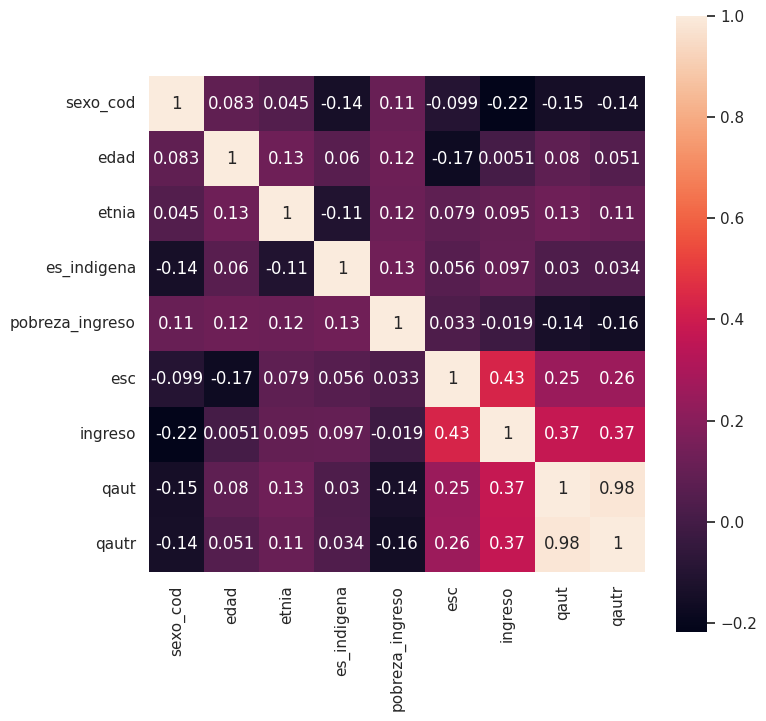

In [ ]:
sns.set()
plt.figure(figsize=(8,8))  # Tamaño personalizado de la figura
sns.heatmap(df_Casen.corr(), square=True, annot=True)
plt.show()

##Usando herramientas: Matriz de dispersión

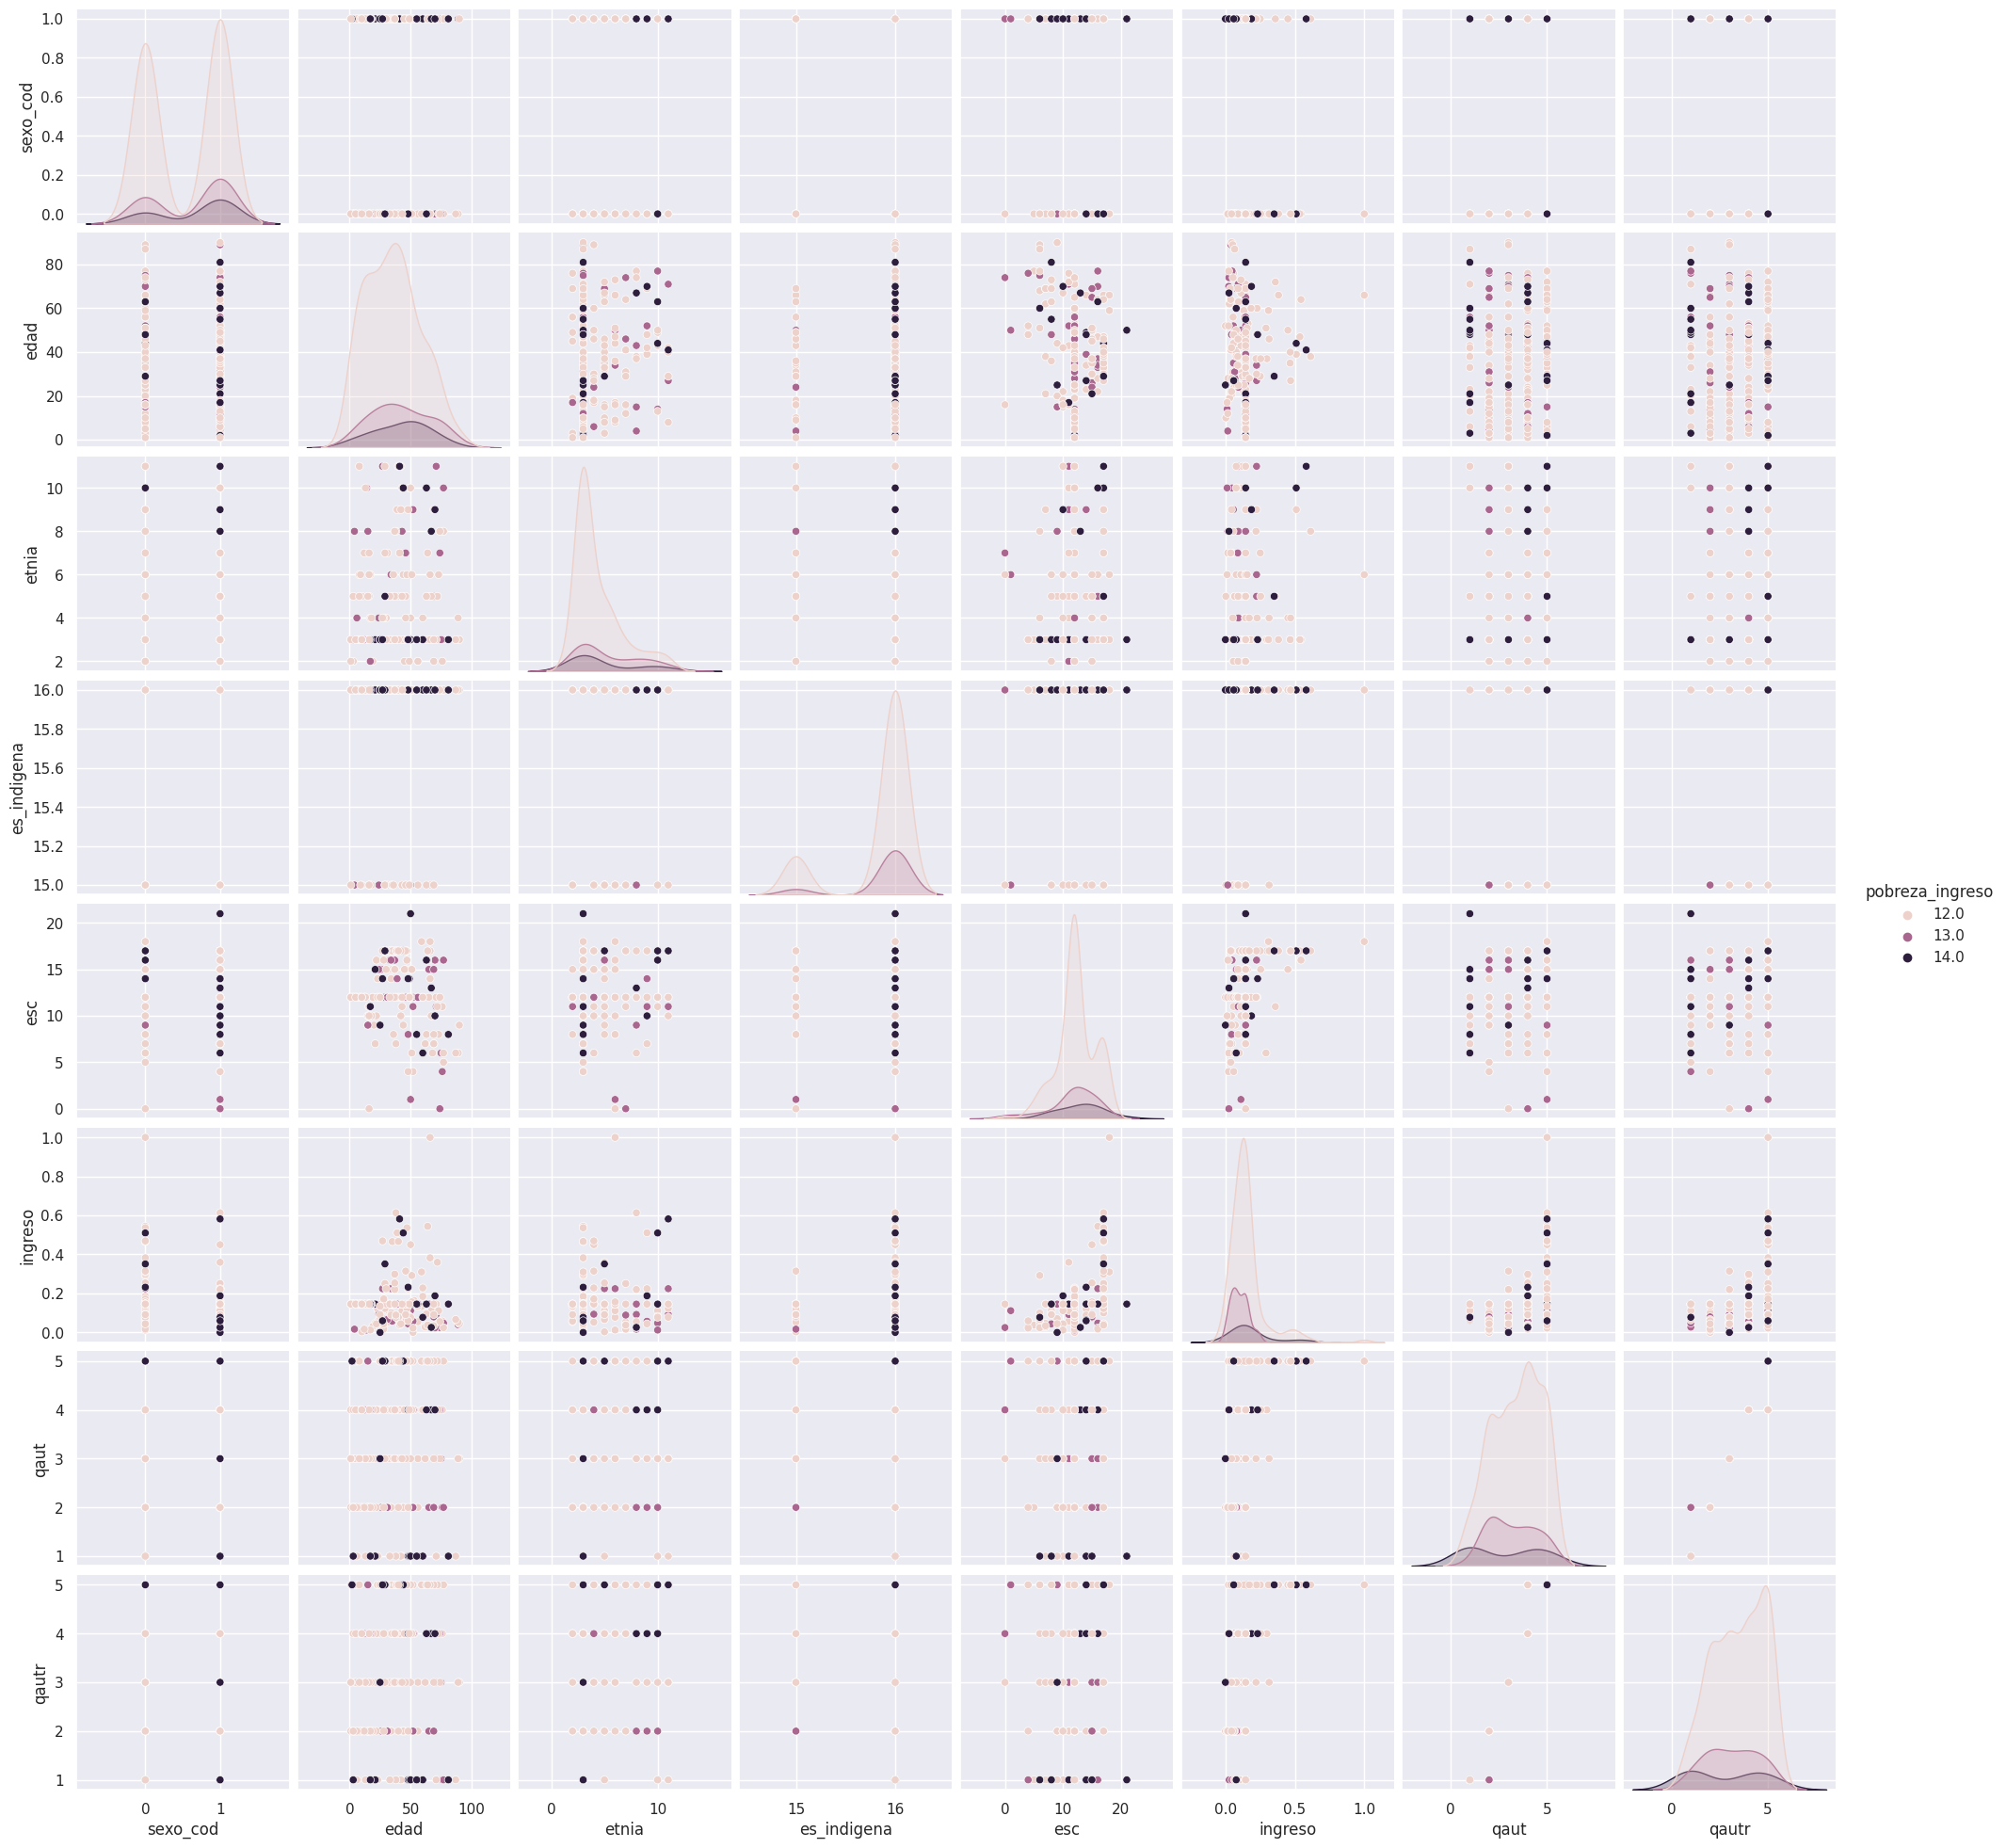

In [ ]:
# Mostrar la matriz de dispersión con colores según la variable "pobreza_ingreso"
sns.pairplot(df_Casen, hue="pobreza_ingreso")


##Usando herramientas: SelectKbest


In [ ]:
name_features_casen = ['sexo_cod', 'edad', 'es_indigena', 'etnia', 'esc', 'ingreso', 'qaut', 'qautr']
X_casen = df_Casen[name_features_casen]
y_casen = df_Casen['pobreza_ingreso']

X_train_casen, X_test_casen, y_train_casen, y_test_casen = train_test_split(X_casen, y_casen, test_size=.2, random_state=42)

X_train_casen_ar = X_train_casen.to_numpy()
y_train_casen_ar = y_train_casen.to_numpy()
X_test_casen_ar = X_test_casen.to_numpy()
# Usar SelectKBest con f_classif para seleccionar las k características que están más correlacionadas
selector = SelectKBest(f_classif, k=4) # En K le indicamos el número de características que queremos seleccionar

# Muestra las características seleccionadas
X_train_casen_char_selected = selector.fit(X_train_casen_ar, y_train_casen_ar)

char_selected = X_train_casen_char_selected.get_feature_names_out(name_features_casen)

# Con este método selecciona las mejores características y filas que no están correlacionadas
X_train_casen_selected = selector.fit_transform(X_train_casen_ar, y_train_casen_ar)
X_test_casen_selected = selector.transform(X_test_casen_ar)

char_selected


array(['etnia', 'ingreso', 'qaut', 'qautr'], dtype=object)

## Usando NaiveBayes modelo (...)

In [ ]:
# Definir las características (features) y la variable objetivo (target) para el modelo
features = df_Casen[['sexo_cod', 'etnia', 'qautr']]
target = df_Casen['pobreza_ingreso']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

names = ["GaussianNB", "MultiNomialNB", 'BernouilliNB', 'ComplementNB','CategoricalNB']
classifiers = [GaussianNB(), MultinomialNB(), BernoulliNB(), ComplementNB(),CategoricalNB()]
# names = ["GaussianNB", "MultiNomialNB", 'BernouilliNB', 'ComplementNB']
# classifiers = [GaussianNB(), MultinomialNB(), BernoulliNB(), ComplementNB()]

cv = KFold(n_splits=5, shuffle=True)
total_scores_cv = []

for name, clf in zip(names, classifiers):
    fold_accuracy = []
    for train_fold, test_fold in cv.split(X_train):
        f_train_x = X_train.iloc[train_fold]
        f_train_y = y_train.iloc[train_fold]
        clf.fit(f_train_x, f_train_y)
        y_pred = clf.predict(X_train.iloc[test_fold])
        acc = accuracy_score(y_train.iloc[test_fold], y_pred)
        fold_accuracy.append(acc)
    total_scores_cv.append(fold_accuracy)

total_scores_mean = [sum(scores)/len(scores) for scores in total_scores_cv]
total_scores_scv = []

###Sin Cross Validation

In [ ]:
print("Sin Cross Validation")
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print("Modelo: %s = %6.2f" % (name, score))

Sin Cross Validation
Modelo: GaussianNB =   0.55
Modelo: MultiNomialNB =   0.60
Modelo: BernouilliNB =   0.62
Modelo: ComplementNB =   0.40
Modelo: CategoricalNB =   0.60


###Con Cross Validation

In [ ]:

print("\nCon Cross Validation")
for i in range(len(names)):
    print("Modelo: %s = %6.2f" % (names[i], total_scores_mean[i]))


Con Cross Validation
Modelo: GaussianNB =   0.74
Modelo: MultiNomialNB =   0.75
Modelo: BernouilliNB =   0.76
Modelo: ComplementNB =   0.57
Modelo: CategoricalNB =   0.75


###Matriz de confusión

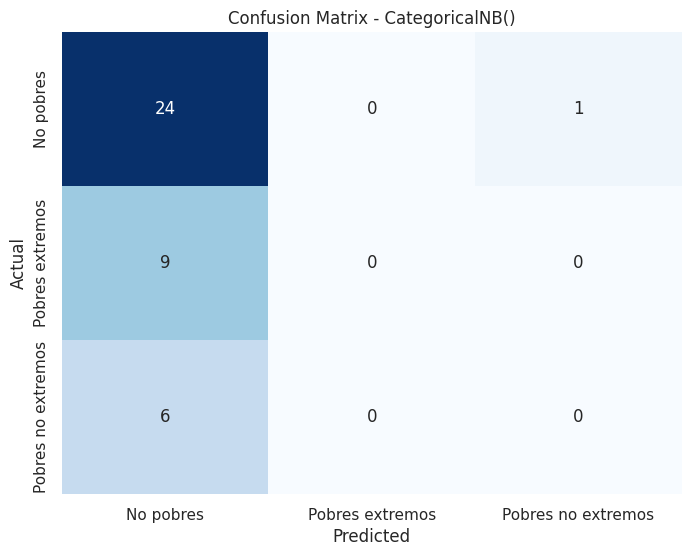

In [ ]:
# Instanciar el modelo y realizar el entrenamiento
model = classifiers[4]
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_model = model.predict(X_test)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_model)

# Visualizar la matriz de confusión usando seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No pobres','Pobres extremos','Pobres no extremos'], yticklabels=['No pobres','Pobres extremos','Pobres no extremos'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {classifiers[4]}')
plt.show()

####Intentamos generar una imagen 3D dinámica por medio de SVC para la visualización de los distintos rangos con la librería Plotly

In [ ]:
X = df_Casen[['sexo_cod', 'etnia', 'qautr']]
y = df_Casen['pobreza_ingreso']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar un modelo SVC para clasificación
model = SVC(kernel='linear')
model.fit(X_train, y_train)

# Definir el tamaño de paso en la malla
h = 0.2

# Definir los límites para las características utilizando los datos de entrenamiento
x_min, x_max = X_train.iloc[:, 0].min() - 1, X_train.iloc[:, 0].max() + 1
y_min, y_max = X_train.iloc[:, 1].min() - 1, X_train.iloc[:, 1].max() + 1
z_min, z_max = X_train.iloc[:, 2].min() - 1, X_train.iloc[:, 2].max() + 1

# Crear la malla para visualizar los hiperplanos en 3D
xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h),
                         np.arange(z_min, z_max, h))

# Crear trazo para puntos de datos
trace_data = go.Scatter3d(
    x=X_train.iloc[:, 0],
    y=X_train.iloc[:, 1],
    z=X_train.iloc[:, 2],
    mode='markers',
    marker=dict(
        size=10,  # Aumenta el tamaño de los puntos
        color=y_train,
        colorscale='Viridis',
        opacity=0.8
    ),
    text=y_train,
    name='Data Points'
)

# Configuración del diseño
layout = go.Layout(
    title='Puntos de datos en 3D',
    scene=dict(
        xaxis=dict(title='sexo_cod'),
        yaxis=dict(title='etnia'),
        zaxis=dict(title='qautr')
    )
)

# Visualización interactiva
fig = go.Figure(data=[trace_data], layout=layout)
fig.show()


Webgrafia:

- https://colab.research.google.com/drive/1_760l-ArDZPws8WNo5XpVYXNQT6T2FH3?hl=es#scrollTo=QD0T9mVLt_qt
- https://colab.research.google.com/drive/1f7pje4J7UxUD6qlRS2wjdWmsVdpaVmVy?hl=es#scrollTo=WXPWzdmax-lx
- https://colab.research.google.com/drive/1nXthaKc-r5L43RoqyhfSPlmmTYLolkAS?usp=sharing#scrollTo=rZ8tJ_75pnf2
- https://www.linkedin.com/pulse/an%C3%A1lisis-exploratorio-de-datos-con-python-almudena-bonaplata/?originalSubdomain=es
- https://joserzapata.github.io/courses/python-ciencia-datos/visualizacion/seaborn/
- https://rpubs.com/dataintelligence/variables_de_la_casen
- https://observatorio.ministeriodesarrollosocial.gob.cl/storage/docs/casen/2017/Programacion_de_Medicion_de_Pobreza_Multidimensional_2017.pdf_Casen
-https://colab.research.google.com/drive/1IB2mJ-Q9yH4JF8gZa0y33BaYJlPLIv72?hl=es


##Conclusiones:
Inicialmente se usó un foco (Y) erróneo, ya que de inicio intenté predecir la etnia a razón de la edad, los ingresos y el sexo del individuo resultando un accuracy bastante bajo, sin superar el 55% en el mejor de los casos con cross Validation. Sin embargo la puesta en práctica de las propias matrices y modelos, me han ido guiando hacia los datos que, ahora sí, creo que serán más indicados para el tratamiento de este ejercicio. Esto sería el de predecir el nivel de pobreza de un individuo X, dada una edad, una etnia y un Quintil autonomo Regional (Qautr) determinados. La validez de la predicción alcanza en este caso el 76% con el modelo GaussianNB tras aplicarle cross validation.

Igualmente no hay que perder de vista que tiene mucho que afinar el manejo de datos y las predicciones hasta el punto de que posiblemente cambie radicalmente, ya que el modelo CategoricalNB alcanza una predicción del 73%, resultado agridulce ya que teóricamente debería ser el que arrojase una mejor predicción al ser un problema de clasificación.